# MUA Detection

## Overview

_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb).
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb).
- Prior to running, please generate sorted spikes with the [spike sorting
  pipeline](./02_Spike_Sorting.ipynb) and generate input position data with
  either the [Trodes](./20_Position_Trodes.ipynb) or DLC notebooks
  ([1](./21_Position_DLC_1.ipynb), [2](./22_Position_DLC_2.ipynb),
  [3](./23_Position_DLC_3.ipynb)).

The goal of this notebook is to populate the `MuaEventsV1` table, which depends `SortedSpikesGroup` and `PositionOutput`.

# Imports

In [1]:
import datajoint as dj
from pathlib import Path

dj.config.load(
    Path("../dj_local_conf.json").absolute()
)  # load config for database connection info

from spyglass.mua.v1.mua import MuaEventsV1, MuaEventsParameters

[2024-06-04 16:03:33,573][INFO]: Connecting denissemorales@lmf-db.cin.ucsf.edu:3306
[2024-06-04 16:03:33,619][INFO]: Connected denissemorales@lmf-db.cin.ucsf.edu:3306
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Select Position Data

In [2]:
from spyglass.position import PositionOutput

# First, select the file of interest
nwb_copy_file_name = "mediumnwb20230802_.nwb"

# Then, get position data
trodes_s_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": "pos 0 valid times",
    "trodes_pos_params_name": "single_led_upsampled",
}

pos_merge_id = (PositionOutput.TrodesPosV1 & trodes_s_key).fetch1("merge_id")
pos_merge_id

UUID('4eb59a18-045a-5768-d12e-b6473415ae1c')

## Select Sorted Spikes Data

In [3]:
from spyglass.spikesorting.analysis.v1.group import (
    SortedSpikesGroup,
)

# Select sorted spikes data
sorted_spikes_group_key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorted_spikes_group_name": "test_group",
    "unit_filter_params_name": "default_exclusion",
}

SortedSpikesGroup & sorted_spikes_group_key

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name
mediumnwb20230802_.nwb,default_exclusion,test_group


# Setting MUA Parameters

In [4]:
MuaEventsParameters()

mua_param_name a name for this set of parameters,mua_param_dict dictionary of parameters
default,=BLOB=


Here are the default parameters:

In [5]:
(MuaEventsParameters() & {"mua_param_name": "default"}).fetch1()

{'mua_param_name': 'default',
 'mua_param_dict': {'minimum_duration': 0.015,
  'zscore_threshold': 2.0,
  'close_event_threshold': 0.0,
  'speed_threshold': 4.0}}

Putting everything together: create a key and populate the MuaEventsV1 table

In [6]:
mua_key = {
    "mua_param_name": "default",
    **sorted_spikes_group_key,
    "pos_merge_id": pos_merge_id,
    "detection_interval": "pos 0 valid times",
}

MuaEventsV1().populate(mua_key)
MuaEventsV1 & mua_key

mua_param_name a name for this set of parameters,nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,pos_merge_id,detection_interval descriptive name of this interval list,analysis_file_name name of the file,mua_times_object_id
default,mediumnwb20230802_.nwb,default_exclusion,test_group,4eb59a18-045a-5768-d12e-b6473415ae1c,pos 0 valid times,mediumnwb20230802_235KSEV39O.nwb,a93532eb-2947-4552-8877-19ea0d2dcc4f


Now we can use `fetch1_dataframe` for mua data, including start times, end times, and speed.

In [7]:
mua_times = (MuaEventsV1 & mua_key).fetch1_dataframe()
mua_times

[16:03:45][WARNING] Spyglass: Multiple classes found in stack: {'`spikesorting_group_v1`.`sorted_spikes_group`', '`mua_v1`.`mua_events_parameters`', '`mua_v1`.`__mua_events_v1`'}. Please submit a bug report with the snippet used.
/home/dmrodriguez/miniforge3/envs/spyglass/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/dmrodriguez/miniforge3/envs/spyglass/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/home/dmrodriguez/miniforge3/envs/spyglass/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
id,,,,,,,,,,,,,
0,1.625936e+09,1.625936e+09,0.238,1.204139,1.220925,2.258331,0.028349,2.760825,1.517296,3.576624,1.427160,2.851154,2.616020
1,1.625936e+09,1.625936e+09,0.120,1.364368,1.349665,2.412096,0.015503,1.803533,0.497099,1.803533,0.464203,0.553494,0.722099
2,1.625936e+09,1.625936e+09,0.082,1.350428,1.490812,2.229001,0.016666,0.639882,0.830598,0.838116,0.639882,0.791716,0.772154
3,1.625936e+09,1.625936e+09,0.074,1.609420,1.803123,2.578417,0.013637,2.690052,0.684351,2.690052,0.684351,1.327693,1.451886
4,1.625936e+09,1.625936e+09,0.208,1.459232,1.441996,2.610289,0.040791,0.208621,1.136773,1.298535,0.162133,1.088990,0.935486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1.625937e+09,1.625937e+09,0.212,3.099559,3.296528,5.312823,0.013042,1.183369,0.500407,1.183369,0.386452,0.827476,0.791367
161,1.625937e+09,1.625937e+09,0.406,2.234536,2.555549,4.133360,0.013230,0.483370,0.415434,0.967244,0.170981,0.615845,0.603776
162,1.625937e+09,1.625937e+09,0.106,1.272785,1.090846,2.567647,0.029594,1.173970,1.531232,1.586072,1.173970,1.533011,1.472277


## Plotting

From this, we can plot MUA firing rate and speed together.

[16:03:49][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[16:03:49][WARNING] Spyglass: Multiple classes found in stack: {'`position_v1_trodes_position`.`__trodes_pos_v1`', '`mua_v1`.`mua_events_parameters`', '`spikesorting_group_v1`.`sorted_spikes_group`', '`mua_v1`.`__mua_events_v1`', '`position_merge`.`position_output`'}. Please submit a bug report with the snippet used.
/home/dmrodriguez/miniforge3/envs/spyglass/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/dmrodriguez/miniforge3/envs/spyglass/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
[16:03:50][WARNING] Spyglass: Multiple classes found in stack: {'`mua_v1`.`mua_events_parameters`', '`spi

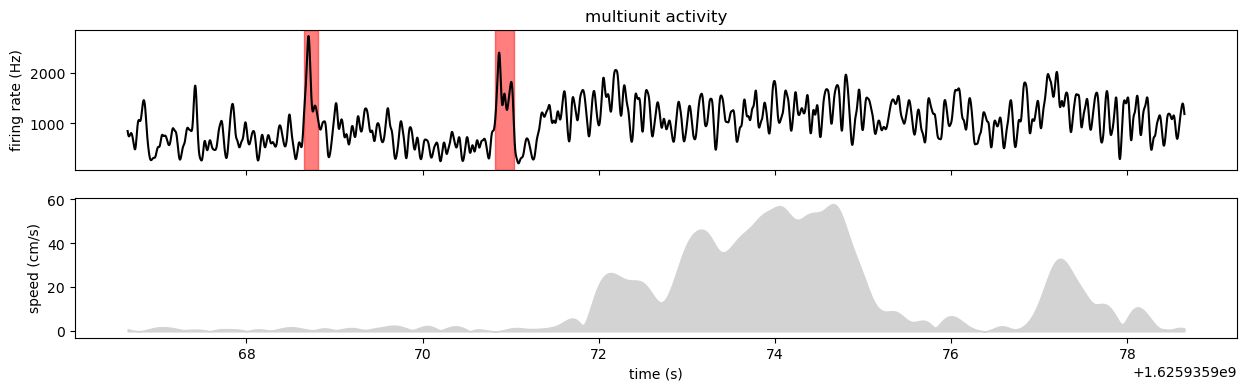

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 4))
speed = MuaEventsV1.get_speed(mua_key)  # get speed from MuaEventsV1 table
time = speed.index.to_numpy()
speed = speed.to_numpy()
multiunit_firing_rate = MuaEventsV1.get_firing_rate(
    mua_key, time
)  # get firing rate from MuaEventsV1 table

time_slice = slice(
    np.searchsorted(time, mua_times.loc[10].start_time) - 1_000,
    np.searchsorted(time, mua_times.loc[10].start_time) + 5_000,
)

axes[0].plot(
    time[time_slice],
    multiunit_firing_rate[time_slice],
    color="black",
)
axes[0].set_ylabel("firing rate (Hz)")
axes[0].set_title("multiunit activity")
axes[1].fill_between(time[time_slice], speed[time_slice], color="lightgrey")
axes[1].set_ylabel("speed (cm/s)")
axes[1].set_xlabel("time (s)")

for id, mua_time in mua_times.loc[
    np.logical_and(
        mua_times["start_time"] > time[time_slice].min(),
        mua_times["end_time"] < time[time_slice].max(),
    )
].iterrows():
    axes[0].axvspan(
        mua_time["start_time"], mua_time["end_time"], color="red", alpha=0.5
    )

We can also create a figurl to visualize the data.

In [9]:
(MuaEventsV1 & mua_key).create_figurl(
    zscore_mua=True,
)

[16:03:57][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[16:03:57][WARNING] Spyglass: Multiple classes found in stack: {'`position_v1_trodes_position`.`__trodes_pos_v1`', '`mua_v1`.`mua_events_parameters`', '`spikesorting_group_v1`.`sorted_spikes_group`', '`mua_v1`.`__mua_events_v1`', '`position_merge`.`position_output`'}. Please submit a bug report with the snippet used.
[16:03:58][WARNING] Spyglass: Multiple classes found in stack: {'`mua_v1`.`mua_events_parameters`', '`spikesorting_group_v1`.`sorted_spikes_group`', '`mua_v1`.`__mua_events_v1`', '`spikesorting_v1_curation`.`curation_v1`', '`spikesorting_merge`.`spike_sorting_output`'}. Please submit a bug report with the snippet used.
[16:03:59][WARNING] Spyglass: Multiple classes found in stack: {'`mua_v1`.`mua_events_parameters`', '`spikesorting_group_v1`.`sorted_spikes_group`', '`mua_v1`.`__mua_events_v1`', '`spikesorting_v1_curation`.`curation_v1`', '`spikesorting_merge`.`spik

'https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://d1774bae95321e5ace99835c7282ae66c52da796&label=Multiunit%20Detection&zone=franklab.default'